# Task 1: Data Analysis (Train)

1- Analyze the dataset for the distribution of the labels by:
- a) Counting the number of images per label,
- b) Mean and variance for the pixel ratio per label: 
  - b1) (# of pixels of label j in image i) / (# of pixels in image i),
  - b2) (# of pixels of label j in image i) / (# of foreground pixels in image i) ====> in this case we exclude the background

## Load Modules and Import Data

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import pylab
import os
from collections import Counter

import cv2
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Constants and configuration settings can be imported
from src import config

# Auxiliary functions can be imported from src.dataset module
from src.dataset import get_image, get_mask, get_annotations, box_label, plot_boxes, plot_mask, overlay_mask

if "notebooks" in os.getcwd():
    print("Running in Jupyter Notebook")

# Colors for the masks
COLORS = [
    (0, 0, 0), (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184),
    (20, 165, 16), (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122),
    (43, 152, 125), (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198), (70, 250, 116),
    (216, 21, 138), (100, 0, 176), (171, 236, 47), (193, 137, 224), (36, 152, 214), (154, 165, 67), (73, 8, 110),
    (67, 161, 255), (167, 146, 11), (136, 126, 185), (44, 52, 10), (25, 33, 189), (73, 197, 184), (20, 165, 16),
    (48, 37, 106), (98, 213, 120), (21, 104, 190), (191, 106, 197), (142, 63, 109), (155, 22, 122), (43, 152, 125),
    (128, 89, 85), (11, 1, 133), (126, 45, 174), (32, 111, 29), (55, 31, 198), (70, 250, 116), (216, 21, 138)
]


# The analysis will be performed on Train dataset (check src.config)

annFile='{}/annotations/instances_attributes_{}.json'.format(config.dataDir,config.dataType) # Annotations json
maskFolder='{}/annotations/{}/'.format(config.dataDir, config.dataType)                      # Mask images
imgFolder='{}/images/{}/'.format(config.dataDir,config.dataType)

# initialize COCO api for instance annotations
db=COCO(annFile)                                                                             # Process the annotations in COCO format
d_cats = {x['id']: x['name'] for x in db.dataset['categories']}                              # Get the categories to encode/decode

for k, v in list(d_cats.items())[:5]:
    print(k, ":", v)

loading annotations into memory...
Done (t=3.07s)
creating index...
index created!
loading annotations into memory...
Done (t=3.31s)
creating index...
index created!
0 : shirt, blouse
1 : top, t-shirt, sweatshirt
2 : sweater
3 : cardigan
4 : jacket


## Check Images and Masks


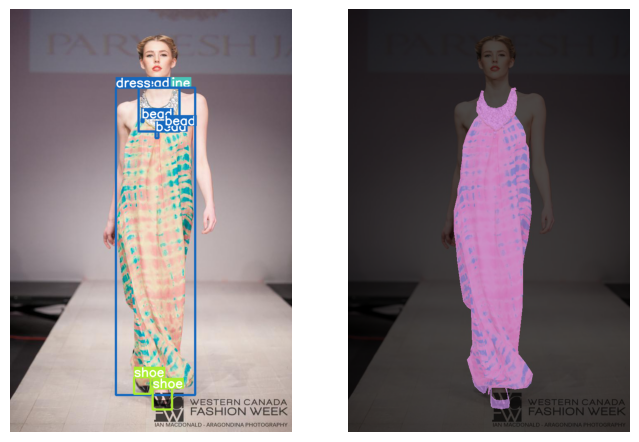

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ids = db.getImgIds()
rnd_id = np.random.choice(ids, 1)
plot_boxes(img_id=rnd_id, ax=ax[0])

image_file = db.loadImgs(rnd_id)[0]['file_name']

overlay_mask(image_file, ax=ax[1])

## a) Number of Images per Label

Steps:

- Create a dictionary with a list of category names for each image id.
- Create the opposite, a dictionary with images id for each category.

Note: for each class, the images in which they appear have no duplicates. However, in a single image the same category can appear more than once (as expected).

In [3]:
tic = time()

# Get the annotations for each image (may be useful)
d_annotations = {img_id:get_annotations(img_id) for img_id in db.getImgIds()}

# Categories per image
d_img_class = {k: [d_cats[x['category_id']] for x in v] for k, v in d_annotations.items()}

# Image per category
d_class_img = {d_cats[cat]: db.getImgIds(catIds=cat) for cat in db.getCatIds()}

print("Time elapsed:", time() - tic)

Time elapsed: 1.2299237251281738


In [4]:
## Check if there are categories with repeated images
for k,v in d_class_img.items():
    if len(set(v)) < len(v):
        print(k)

## Check if there are images with repeated categories
n_show = 5
i=0
for k,v in d_img_class.items():
    if len(set(v)) < len(v):
        print(k, v)
    if i > n_show:
        break
    i+=1

16145 ['shoe', 'shoe', 'shorts']
12446 ['hat', 'neckline', 'sleeve', 'sleeve', 'top, t-shirt, sweatshirt', 'watch']
17264 ['coat', 'collar', 'pocket', 'pocket', 'pocket', 'sleeve', 'pocket', 'sleeve', 'shirt, blouse', 'collar', 'hat']
10359 ['coat', 'sleeve', 'sleeve', 'pocket', 'lapel', 'hood', 'scarf', 'hat', 'glasses']
17672 ['glasses', 'shirt, blouse', 'collar', 'collar', 'sleeve', 'sleeve', 'bag, wallet', 'jacket']
9459 ['shirt, blouse', 'collar', 'top, t-shirt, sweatshirt', 'neckline', 'jacket', 'hood', 'sleeve', 'sleeve', 'zipper', 'pocket', 'zipper', 'pocket', 'pocket']


From the plot below we can see that neckline, sleeve and shoes appear really often in the images. On the other hand, the categories "leg_warmer" and "tassel" are the least common.

Be careful, the same image can appear for more than one category, so the sum of the number of images per category is greater than the total number of images.

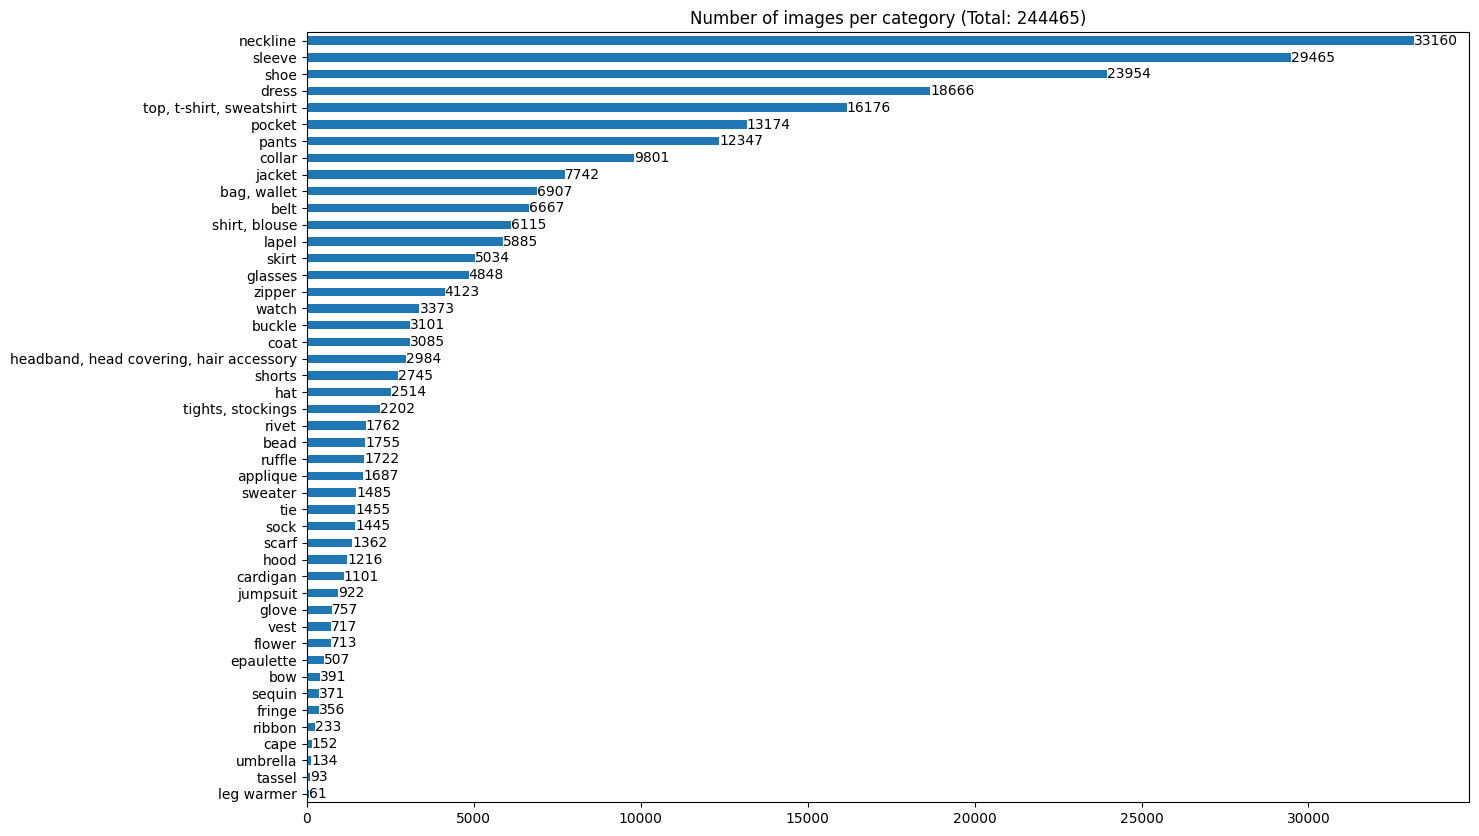

In [5]:
df_class_img = pd.DataFrame({k:[len(v)] for k,v in d_class_img.items()}).T
df_class_img.rename({0:'category'}, axis=1, inplace=True)
total = df_class_img['category'].sum()
fig, ax = plt.subplots(figsize=(15, 10))
df_class_img.sort_values(by='category').plot(kind='barh', title = f"Number of images per category (Total: {total})", ax=ax, legend=False)
for bar in ax.patches:
    plt.text(bar.get_width(), bar.xy[1], f"{bar.get_width()}")

In [6]:
img_filenames = sorted(os.listdir(imgFolder))
mask_filenames = sorted(os.listdir(maskFolder))

assert len(img_filenames) == len(mask_filenames), "Number of images and masks do not match"
print(f"Number of images: {len(img_filenames)}")
print(f"Number of masks: {len(mask_filenames)}")

print("The ratio of objects to images is {:.2f} (without object repetition)".format(total/len(db.getImgIds())))
print("The ratio of objects to images is {:.2f} (with object repetition)".format(len(db.getAnnIds())/len(db.getImgIds())))

Number of images: 45623
Number of masks: 45623
The ratio of objects to images is 5.36 (without object repetition)
The ratio of objects to images is 7.31 (with object repetition)


In [7]:
df_class_img

,category
"shirt, blouse",6115
"top, t-shirt, sweatshirt",16176
sweater,1485
cardigan,1101
jacket,7742
vest,717
pants,12347
shorts,2745
skirt,5034
coat,3085


In [8]:
np.percentile(df_class_img['category'], 75)

6057.5

In [25]:
overrep = list(df_class_img.sort_values(by='category', ascending=False)[df_class_img['category'] > np.percentile(df_class_img['category'], 40)].index)
overrep

/tmp/ipykernel_7608/2681149093.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrep = list(df_class_img.sort_values(by='category', ascending=False)[df_class_img['category'] > np.percentile(df_class_img['category'], 40)].index)


['neckline',
 'sleeve',
 'shoe',
 'dress',
 'top, t-shirt, sweatshirt',
 'pocket',
 'pants',
 'collar',
 'jacket',
 'bag, wallet',
 'belt',
 'shirt, blouse',
 'lapel',
 'skirt',
 'glasses',
 'zipper',
 'watch',
 'buckle',
 'coat',
 'headband, head covering, hair accessory',
 'shorts',
 'hat',
 'tights, stockings',
 'rivet',
 'bead',
 'ruffle',
 'applique']

## b) Pixel Ratio per Label

### b1) (# of pixels of label j in image i) / (# of pixels in image i)

Image ID: 16145
Number of pixels per category: {'shorts': 96132, 'shoe': 46875}
Relative number of pixels per category: {'shorts': 0.09167861938476562, 'shoe': 0.04470348358154297}


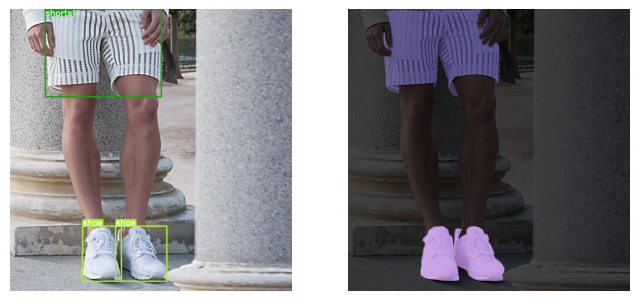

In [10]:
# get an exampe image
id = ids[0]
print("Image ID:", id)
mask = get_mask(id)
mask_vals = mask[mask > 0]

d_pixels = Counter(mask_vals)
# Important to use the background category
d_pixels = {config.d_cats_bg[k]: v for k, v in d_pixels.items()}
d_pixels_rel = {k: v / mask.size for k, v in d_pixels.items()}

# Plot image and mask
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
plot_boxes(img_id=id, ax=ax[0])
image_file = db.loadImgs(id)[0]['file_name']

overlay_mask(image_file, ax=ax[1])

print("Number of pixels per category:", d_pixels)
print("Relative number of pixels per category:", d_pixels_rel)

In [11]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [15]:
# Create a thread pool to process the images in parallel
import concurrent.futures
from collections import Counter
import json

###### UNCOMMENT FIRST TIME TO CREATE d_pixels_rel_out.json ######

# def process_id(id):
#     mask = get_mask(id)
#     mask_vals = mask[mask > 0]
#     d_pixels = Counter(mask_vals)
#     d_pixels = {config.d_cats_bg[k]: v for k, v in d_pixels.items()}
#     d_pixels_rel = {k: v / mask.size for k, v in d_pixels.items()}
#     return d_pixels_rel

# d_pixels_rel_out = {}
# with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
#     futures = {executor.submit(process_id, id): id for id in ids}
#     for future in concurrent.futures.as_completed(futures):
#         id = futures[future]
#         try:
#             result = future.result()
#             for k, v in result.items():
#                 d_pixels_rel_out.setdefault(k, []).append(v)
#         except Exception as exc:
#             print(f'Error processing id {id}: {exc}')

# with open('datasets/fashion/d_pixels_rel_out_bg.json', 'w') as f:
#     json.dump(d_pixels_rel_out, f)

with open('datasets/fashion/d_pixels_rel_out_bg.json', 'r') as f:
    d_pixels_rel_out = json.load(f)

for k, v in d_pixels_rel_out.items():
    print(k, ":", v[:5])


hood : [0.0035998212976539588, 0.0028137028042521995, 0.0013128147893772895, 0.013896942138671875, 0.09091567993164062]
collar : [0.0004925769794721408, 0.004848496980234261, 0.00016466962976539588, 0.0029912596224340175, 0.0070203032817109145]
top, t-shirt, sweatshirt : [0.021388437041788857, 0.18898677825927734, 0.03606694464809384, 0.02717074258784773, 0.04570398288799414]
jacket : [0.035047424853372436, 0.06838082219985359, 0.0835233000366569, 0.02487560788904899, 0.008872235223935388]
sleeve : [0.02521879582111437, 0.10463108275293255, 0.03693493777452416, 0.02731224798387097, 0.04767144722622478]
pocket : [0.002132113728005865, 0.0007048979685212299, 0.010361299486803519, 0.00011472099853157122, 0.002185094391495601]
pants : [0.05356631460777126, 0.08267609580893119, 0.010110715267595308, 0.0183137734030837, 0.053841050512445095]
shoe : [0.021587472507331378, 0.0014240940702781844, 0.009200848737188872, 0.010832397818914955, 0.03031143056556196]
neckline : [0.006485939025878906, 

In [16]:
d_pixels_rel_out

{'hood': [0.0035998212976539588,
  0.0028137028042521995,
  0.0013128147893772895,
  0.013896942138671875,
  0.09091567993164062,
  0.0050835742474302495,
  0.0032656936310395315,
  0.004655138837976539,
  0.010163307189941406,
  0.04399270450367647,
  0.002893889754398827,
  0.0018466418579626972,
  0.011999404325513196,
  0.01845531798245614,
  0.016941957000652742,
  0.005565833486070381,
  0.037201881408691406,
  0.024871010193850268,
  0.014008839925130209,
  0.02928828354105572,
  0.008341789245605469,
  0.0024900911840175953,
  0.0005561973828696926,
  0.0037143740835777128,
  0.0032780519005847952,
  0.021618594490521326,
  0.005126953125,
  0.011056746431185944,
  0.0049953460693359375,
  0.047489166259765625,
  0.002461452987536657,
  0.04629063760080645,
  0.010424296061197916,
  0.014373236576607388,
  0.013196480938416423,
  0.0020649659567039107,
  0.007481728830645161,
  0.004668026026392962,
  0.003322181519138756,
  0.009917407441348974,
  0.017356178977272728,
  0.059

In [17]:
df_pixels_rel = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d_pixels_rel_out.items() ]))

pixels_mean = df_pixels_rel.aggregate(['mean', 'std'], axis=0).T

# #.reset_index(drop=False).sort_values()
# pixels_mean = pixels_mean.reset_index(drop=False).\
#                           rename({'index':'category', 0:'mean'}, axis=1).\
#                           sort_values(by='mean', ascending=False)


pixels_mean = pixels_mean.sort_values(by='mean', ascending=False)
pixels_mean

,mean,std
sweater,0.151314,0.144416
dress,0.145040,0.112341
cape,0.142893,0.138090
jumpsuit,0.116494,0.092510
coat,0.107656,0.097467
cardigan,0.107231,0.138395
"top, t-shirt, sweatshirt",0.088920,0.122765
skirt,0.085004,0.094493
jacket,0.075195,0.079408
umbrella,0.072486,0.067761


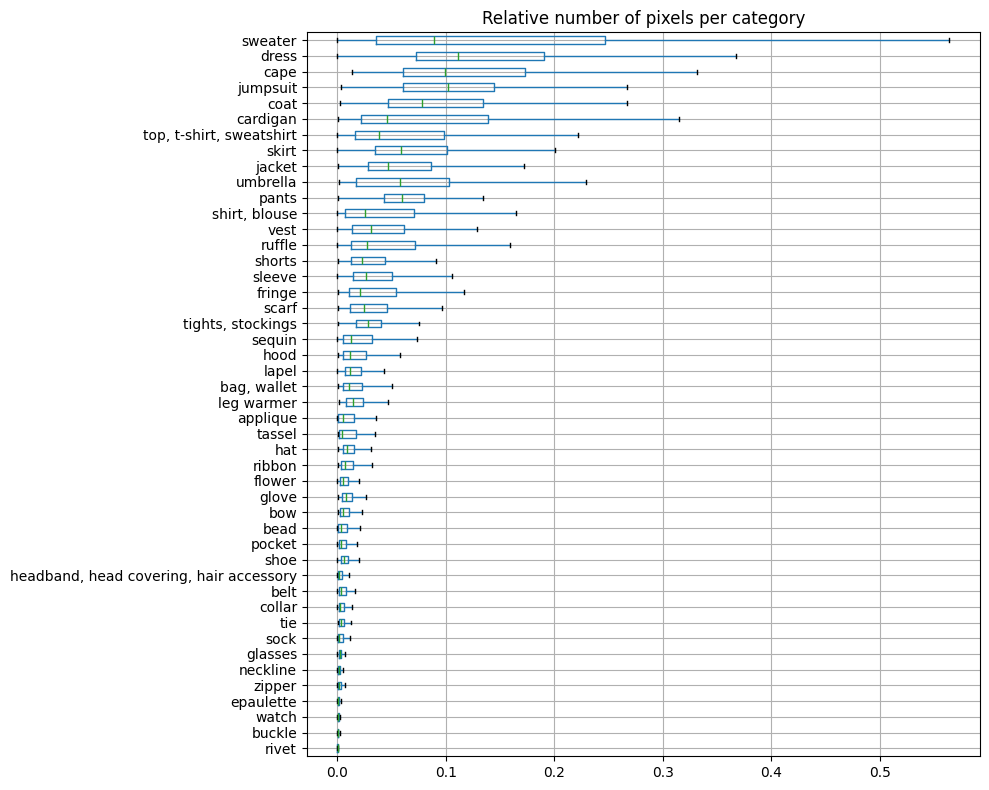

In [72]:
# Boxplot of the relative number of pixels per category
pixels_mean_aux = pixels_mean.sort_values(by="mean", ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
df_pixels_rel = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d_pixels_rel_out.items() ]))
df_pixels_rel = df_pixels_rel.loc[:, pixels_mean_aux.index]
df_pixels_rel.boxplot(rot=0,  vert=False, ax=ax, showfliers=False)
ax.set_title("Relative number of pixels per category")
plt.tight_layout()

<ErrorbarContainer object of 3 artists>

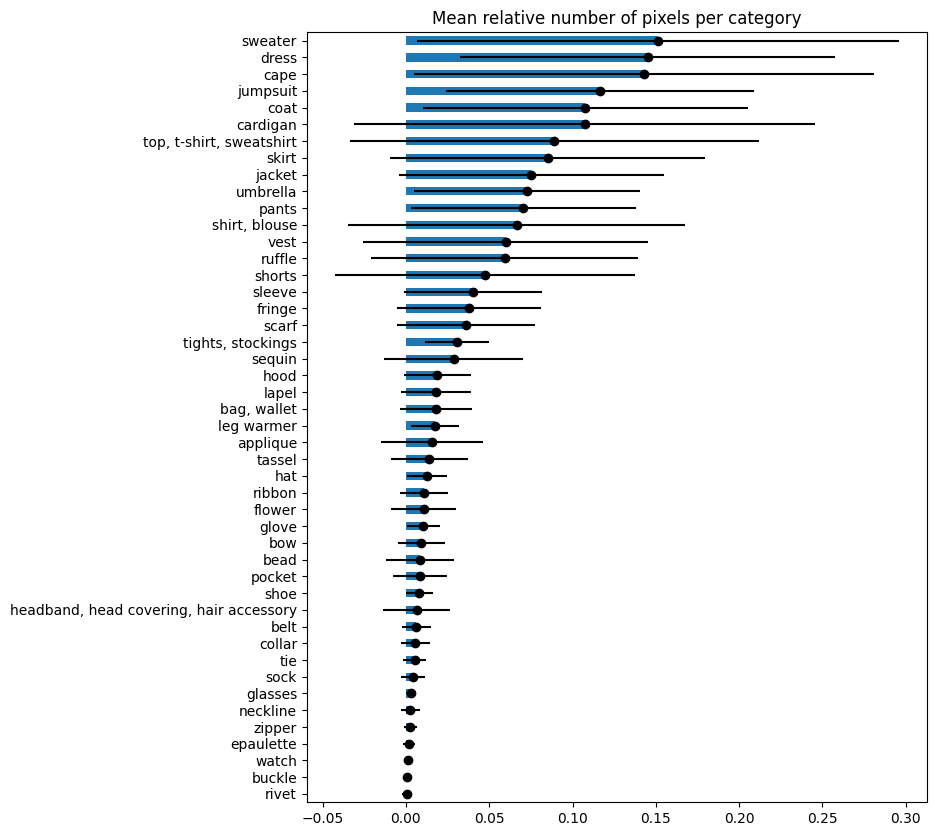

In [73]:
pixels_mean_aux["mean"].plot(kind='barh', title='Mean relative number of pixels per category')

plt.errorbar(pixels_mean_aux["mean"], pixels_mean_aux.index, xerr=pixels_mean_aux["std"], fmt="o", color="k")

### b2) FOREGROUND: (# of pixels of label j in image i) / (# of pixels in image i)

Image ID: 16145
Number of pixels per category: {'shorts': 96132, 'shoe': 46875}
Relative number of pixels per category: {'shorts': 0.6722188424342864, 'shoe': 0.3277811575657136}
neckline : [0.009610353145380522, 0.00540614462825811, 0.009173029545891356, 0.0014164921397721447, 0.004790538331414275]
coat : [0.489732365065792, 0.6254503339843499, 0.30455450018683794, 0.38945879519084664, 0.137237794206003]
sleeve : [0.1941597641443212, 0.07107904937327185, 0.13391176483614797, 0.18555178017432414, 0.2324446368701091]
belt : [0.024829936313861625, 0.10329368827272611, 0.11701173480828164, 0.023587464347582635, 0.004215323040819115]
buckle : [0.006451571733054254, 0.006427542704268931, 0.0076116817442124975, 0.0010648814164128364, 0.0035754273655468657]
tights, stockings : [0.2105726647352367, 0.23300861192460437, 0.3091557459008415, 0.2548566865158591, 0.18584292146073036]
shoe : [0.06464334486235371, 0.0652944979295162, 0.06826970705552128, 0.016916144256329337, 0.03699190730182086]
lap

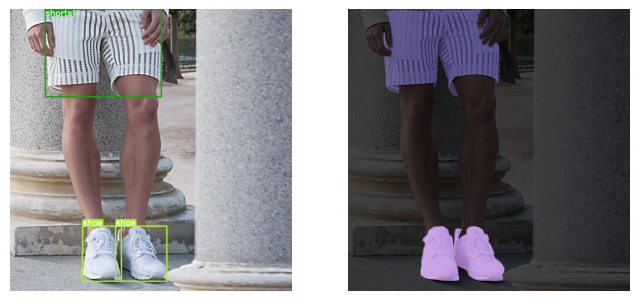

In [18]:
# get an exampe image
id = ids[0]
print("Image ID:", id)
mask = get_mask(id)
mask_vals = mask[mask > 0]

d_pixels = Counter(mask_vals)
# Important to use the background category
d_pixels = {config.d_cats_bg[k]: v for k, v in d_pixels.items()}
d_pixels_rel_fg = {k: v / mask_vals.size for k, v in d_pixels.items()}

# Plot image and mask
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
plot_boxes(img_id=id, ax=ax[0])
image_file = db.loadImgs(id)[0]['file_name']

overlay_mask(image_file, ax=ax[1])

print("Number of pixels per category:", d_pixels)
print("Relative number of pixels per category:", d_pixels_rel_fg)


###### UNCOMMENT FIRST TIME TO CREATE d_pixels_rel_out.json ######

# def process_id_fg(id):
#     mask = get_mask(id)
#     mask_vals = mask[mask > 0]
#     d_pixels = Counter(mask_vals)
#     d_pixels = {config.d_cats_bg[k]: v for k, v in d_pixels.items()}
#     d_pixels_rel = {k: v / mask_vals.size for k, v in d_pixels.items()}
#     return d_pixels_rel

# d_pixels_rel_out_fg = {}
# with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
#     futures = {executor.submit(process_id_fg, id): id for id in ids}
#     for future in concurrent.futures.as_completed(futures):
#         id = futures[future]
#         try:
#             result = future.result()
#             for k, v in result.items():
#                 d_pixels_rel_out_fg.setdefault(k, []).append(v)
#         except Exception as exc:
#             print(f'Error processing id {id}: {exc}')

# with open('datasets/fashion/d_pixels_rel_out_fg.json', 'w') as f:
#     json.dump(d_pixels_rel_out_fg, f)

with open('datasets/fashion/d_pixels_rel_out_fg.json', 'r') as f:
    d_pixels_rel_out_fg = json.load(f)

for k, v in d_pixels_rel_out_fg.items():
    print(k, ":", v[:5])

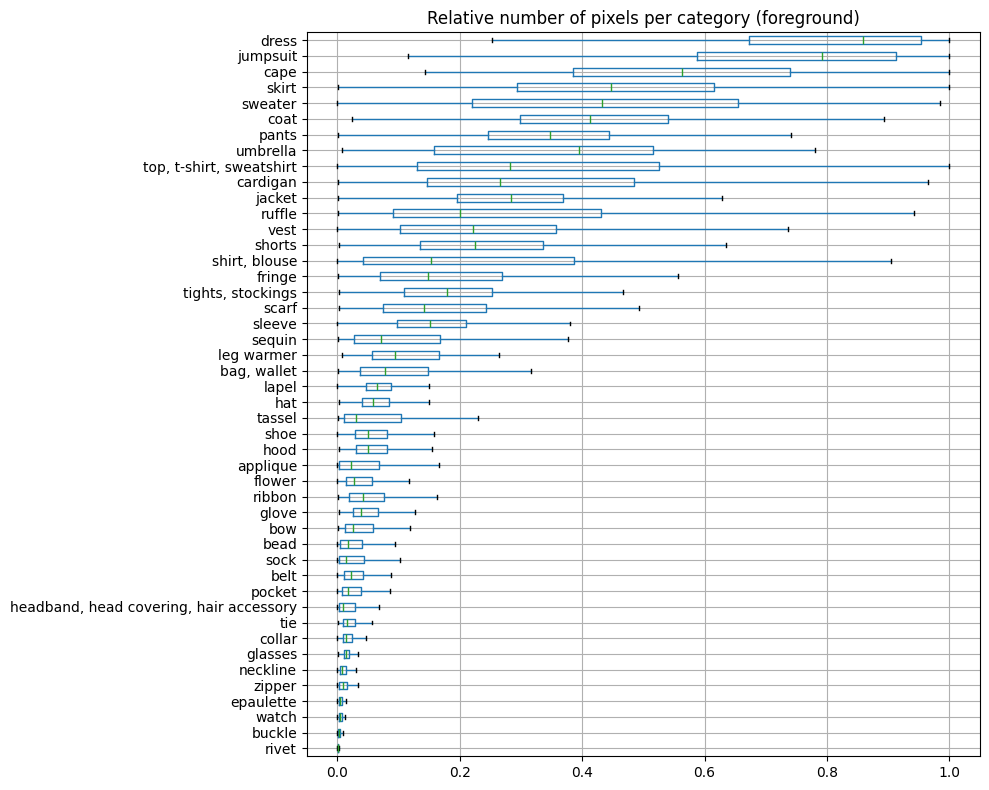

<ErrorbarContainer object of 3 artists>

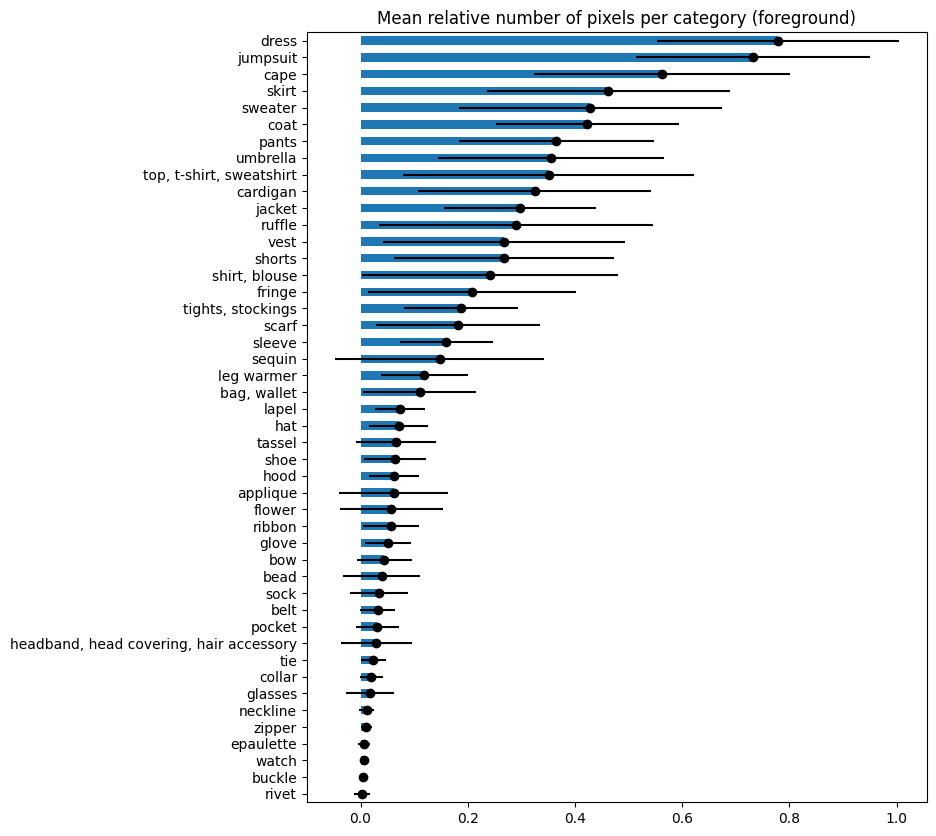

In [20]:
df_pixels_rel_fg = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d_pixels_rel_out_fg.items() ]))

pixels_mean_fg = df_pixels_rel_fg.aggregate(['mean', 'std'], axis=0).T

# #.reset_index(drop=False).sort_values()
# pixels_mean = pixels_mean.reset_index(drop=False).\
#                           rename({'index':'category', 0:'mean'}, axis=1).\
#                           sort_values(by='mean', ascending=False)


pixels_mean_fg = pixels_mean_fg.sort_values(by='mean', ascending=False)

# Boxplot of the relative number of pixels per category
pixels_mean_aux_fg = pixels_mean_fg.sort_values(by="mean", ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
df_pixels_rel_fg = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d_pixels_rel_out_fg.items() ]))
df_pixels_rel_fg = df_pixels_rel_fg.loc[:, pixels_mean_aux_fg.index]
df_pixels_rel_fg.boxplot(rot=0,  vert=False, ax=ax, showfliers=False)
ax.set_title("Relative number of pixels per category (foreground)")
plt.tight_layout()

plt.show()

pixels_mean_aux_fg["mean"].plot(kind='barh', title='Mean relative number of pixels per category (foreground)')

plt.errorbar(pixels_mean_aux_fg["mean"], pixels_mean_aux_fg.index, xerr=pixels_mean_aux_fg["std"], fmt="o", color="k")

In [24]:
oversize = list(pixels_mean_fg.sort_values(by='mean', ascending=False)[pixels_mean_fg['mean'] > np.percentile(pixels_mean_fg['mean'], 40)].index)
oversize

['dress',
 'jumpsuit',
 'cape',
 'skirt',
 'sweater',
 'coat',
 'pants',
 'umbrella',
 'top, t-shirt, sweatshirt',
 'cardigan',
 'jacket',
 'ruffle',
 'vest',
 'shorts',
 'shirt, blouse',
 'fringe',
 'tights, stockings',
 'scarf',
 'sleeve',
 'sequin',
 'leg warmer',
 'bag, wallet',
 'lapel',
 'hat',
 'tassel',
 'shoe',
 'hood']

In [40]:
ls_eliminate = list(set(overrep) & set(oversize))
print(ls_eliminate)

['shorts', 'lapel', 'top, t-shirt, sweatshirt', 'jacket', 'coat', 'sleeve', 'pants', 'dress', 'skirt', 'shirt, blouse', 'bag, wallet', 'ruffle', 'hat', 'tights, stockings', 'shoe']


In [39]:
d_invert_class = {v: k for k, v in d_cats.items()}
ls_eliminate_num = [d_invert_class[x] + 1 for x in ls_eliminate]
ls_eliminate_num

[8, 30, 2, 5, 10, 32, 7, 11, 9, 1, 25, 44, 15, 22, 24]

In [34]:
d_invert_class

{'shirt, blouse': 0,
 'top, t-shirt, sweatshirt': 1,
 'sweater': 2,
 'cardigan': 3,
 'jacket': 4,
 'vest': 5,
 'pants': 6,
 'shorts': 7,
 'skirt': 8,
 'coat': 9,
 'dress': 10,
 'jumpsuit': 11,
 'cape': 12,
 'glasses': 13,
 'hat': 14,
 'headband, head covering, hair accessory': 15,
 'tie': 16,
 'glove': 17,
 'watch': 18,
 'belt': 19,
 'leg warmer': 20,
 'tights, stockings': 21,
 'sock': 22,
 'shoe': 23,
 'bag, wallet': 24,
 'scarf': 25,
 'umbrella': 26,
 'hood': 27,
 'collar': 28,
 'lapel': 29,
 'epaulette': 30,
 'sleeve': 31,
 'pocket': 32,
 'neckline': 33,
 'buckle': 34,
 'zipper': 35,
 'applique': 36,
 'bead': 37,
 'bow': 38,
 'flower': 39,
 'fringe': 40,
 'ribbon': 41,
 'rivet': 42,
 'ruffle': 43,
 'sequin': 44,
 'tassel': 45}